## Classifying documents with embeddings

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/packt_nlp_tensorflow_2/blob/master/Ch04-Advance-Word-Vectors/ch4_document_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from six.moves.urllib.request import urlretrieve
import zipfile
import numpy as np
import pandas as pd
import os
import time
import random
import tensorflow as tf
from matplotlib import pylab

## Downloading the data

This code downloads a [BBC dataset](hhttp://mlg.ucd.ie/files/datasets/bbc-fulltext.zip) consisting of news articles published by BBC. 

In [2]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'


def download_data(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""
    
    # Create the data directory if not exist
    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, 'bbc-fulltext.zip')
    
    # If file doesnt exist, download
    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")
  
    extract_path = os.path.join(data_dir, 'bbc')
    
    # If data has not been extracted already, extract data
    if not os.path.exists(extract_path):        
        with zipfile.ZipFile(os.path.join(data_dir, 'bbc-fulltext.zip'), 'r') as zipf:
            zipf.extractall(data_dir)
    else:
        print("bbc-fulltext.zip has already been extracted")
    
download_data(url, 'data')

File already exists
bbc-fulltext.zip has already been extracted


### Read Data

Here we read all the files and keep them as a list of strings, where each string is a single article

In [26]:
def read_data(data_dir):
    
    # This will contain the full list of stories
    news_stories = []    
    filenames = []
    print("Reading files")
    
    i = 0 # Just used for printing progress
    for root, dirs, files in os.walk(data_dir):
        
        for fi, f in enumerate(files):
            
            # We don't read the readme file
            if 'readme' in f.lower():
                continue
            
            # Printing progress
            i += 1
            print("."*i, f, end='\r')
            
            # Open the file
            with open(os.path.join(root, f), encoding='latin-1') as text_file:
                
                story = []
                # Read all the lines
                for row in text_file:
                                        
                    story.append(row.strip())
                    
                # Create a single string with all the rows in the doc
                story = ' '.join(story)                        
                # Add that to the list
                news_stories.append(story)  
                filenames.append(os.path.join(root, f))
                
        print('', end='\r')
        
    print(f"\nDetected {len(news_stories)} stories")
    return news_stories, filenames
                
  
news_stories, filenames = read_data(os.path.join('data', 'bbc'))

# Printing some stats and sample data
print(f"{sum([len(story.split(' ')) for story in news_stories])} words found in the total news set")
print('Example words (start): ',news_stories[0][:50])
print('Example words (end): ',news_stories[-1][-50:])

Reading files
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Build a Tokenizer

Here we build a tokenizer, that performs simple preprocessing like,

* Converting letters to lower case
* Removing punctuation

and tokenize the strings based on a defined separator. Then each token is converted to an Integer ID, as computers understand numbers, not strings. In the background, the tokenizer builds a word to index dictionary, that defines a unique ID for each word in the vocabulary.

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

n_vocab = 15000 + 1
tokenizer = Tokenizer(
    num_words=n_vocab - 1,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', oov_token=''
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")

Data fitted on the tokenizer


## Generate labels for data

We generate a label using the filenames to train a classifier

In [28]:
labels_ser = pd.Series(filenames, index=filenames).str.split(os.path.sep, expand=True).iloc[:, -2].map(
    {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
)
labels_ser.head()

data\bbc\business\001.txt    0
data\bbc\business\002.txt    0
data\bbc\business\003.txt    0
data\bbc\business\004.txt    0
data\bbc\business\005.txt    0
Name: 2, dtype: int64

## Create train/test split

Here we use 67% data as training and 33% as testing data.

In [29]:
from sklearn.model_selection import train_test_split

train_labels, test_labels = train_test_split(labels_ser, test_size=0.33)

## Generating document embeddings

Here we write a function to generate document embeddings from the previous embedding arrays we saved to the disk for `skip-gram`, `CBOW` and `GloVe` algorithms.

In [30]:
def generate_document_embeddings(texts, filenames, tokenizer, embeddings):
    
    """ This function takes a sequence of tokens and compute the mean embedding vector \
    from the word vectors of all the tokens in the document """
    
    doc_embedding_df = [] # Contains document embeddings for all the articles
    assert isinstance(embeddings, pd.DataFrame), 'embeddings must be a pd.DataFrame'
    
    # This is a trick we use to quickly get the text preprocessed by the tokenizer
    # We first convert text to a sequences, and then back to text, which will give the
    # preprocessed tokens
    sequences = tokenizer.texts_to_sequences(texts)    
    preprocessed_texts = tokenizer.sequences_to_texts(sequences)
    
    # For each text,
    for text in preprocessed_texts:
        # Make sure we had matches for tokens in the embedding matrx
        assert embeddings.loc[text.split(' '), :].shape[0]>0
        # Compute mean of all the embeddings associated with words
        mean_embedding = embeddings.loc[text.split(' '), :].mean(axis=0)
        # Add that to list
        doc_embedding_df.append(mean_embedding)
        
    # Save the doc embeddings in a dataframe
    doc_embedding_df = pd.DataFrame(doc_embedding_df, index=filenames)
    
    return doc_embedding_df


## Compute skip-gram based document embeddings

In [31]:
# Load the skip-gram embeddings context and target
skipgram_context_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/skipgram_embeddings', 'context_embedding.pkl')
)
skipgram_target_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/skipgram_embeddings', 'target_embedding.pkl')
)
skipgram_context_embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
NaN,-1.427625,-1.154279,-1.027655,1.363687,1.353831,-1.211860,1.279560,-1.315888,0.602955,1.220195,...,-1.448210,-1.254843,-0.995438,-1.339593,1.134659,1.427381,1.354307,-1.187261,-1.243143,1.494999
,-0.327097,-0.521317,0.205179,-0.177167,0.016888,-0.510694,0.216325,-0.236522,-0.234402,0.096585,...,-0.483350,-0.541382,0.268705,0.125636,0.116332,0.349278,0.036865,0.191476,0.131313,0.323932
the,-0.044946,-0.009830,-0.782439,-0.040411,0.141403,-0.141793,-0.206453,-0.166947,-0.143746,0.096245,...,-0.103055,0.063623,0.202459,-0.460181,0.388977,0.098845,0.169221,0.060449,0.167599,0.137362
to,-0.097616,-0.028466,0.373821,-0.009577,0.083440,-0.904716,-0.029045,-0.154992,1.113204,-0.057169,...,0.026706,-0.181484,0.122591,-0.298591,-0.099004,-0.004557,-0.004320,0.022960,-0.197245,0.600641
of,-0.518225,0.079831,0.218721,0.063918,0.070212,0.149180,-0.034519,0.094533,-0.077960,0.268403,...,-0.827636,-0.024029,-1.102254,-0.748013,1.626101,0.077321,-0.022681,-0.401835,-0.025986,0.779170
and,-0.380675,-0.060902,0.467516,0.039847,-0.072255,-0.297857,0.486448,-0.153416,-0.105748,0.062139,...,-0.224600,0.237030,0.147239,-0.390464,-0.542171,0.237066,0.244738,0.113206,0.120161,0.542526
a,-0.281075,-0.091397,0.542255,0.244439,0.282127,0.126421,0.394537,-0.483896,2.149094,0.366463,...,-0.297622,0.075509,0.131862,-0.245451,-0.061112,0.233343,0.208846,0.145481,0.015640,0.244263
in,-0.658752,-0.482500,0.311281,-0.085630,-0.255787,0.268496,0.084899,0.272683,1.179264,0.066926,...,0.051931,-0.338828,-0.167985,0.386470,1.433977,-0.077181,0.968448,0.411699,-0.514699,0.242268
for,-0.318278,0.152649,0.146557,0.309478,-0.197440,0.130187,-0.253964,-0.341225,1.062025,0.092227,...,-0.129353,-0.245434,-0.024825,0.148060,0.515092,0.760889,0.231376,0.088485,-0.387053,-0.181140
is,-0.215979,0.173202,-0.759992,0.860715,0.550769,0.034918,0.289527,-0.661340,-0.389477,1.165248,...,-0.350128,0.061945,0.086671,0.178867,1.337760,0.410331,0.439239,0.141097,0.037151,0.528937


In [32]:
# Compute the mean of context & target embeddings for better embeddings
skipgram_embeddings = (skipgram_context_embeddings + skipgram_target_embeddings)/2
# Generate the document embeddings with the average context target embeddings
skipgram_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, skipgram_embeddings)

## Train a document classifier

Here we train a simple document classifier, using document embeddings as inputs and labels we generated as targets. To get a consistent measure, we will run several trials.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def get_classification_accuracy(doc_embeddings, train_labels, test_labels, n_trials):
    """ Train a simple MLP model for several trials and measure test accuracy"""
    
    accuracies = [] # Store accuracies across trials
    
    print(doc_embeddings.loc[train_labels.index])
    print(train_labels.astype('int'))
    # For each trial
    for trial in range(n_trials):
        # Create a MLP classifier
        lr_classifier = LogisticRegression(multi_class='multinomial', max_iter=500)
        
        # Fit the model on training data
        lr_classifier.fit(doc_embeddings.loc[train_labels.index], train_labels)
        
        # Get the predictions for test data
        predictions = lr_classifier.predict(doc_embeddings.loc[test_labels.index])
    
        # Compute accuracy
        accuracies.append(accuracy_score(predictions, test_labels))
    
    return accuracies

# Get classification accuracy for skip-gram models
skipgram_accuracies = get_classification_accuracy(
    skipgram_doc_embeddings, train_labels.astype('int'), test_labels.astype('int'), n_trials=5
)

print(f"Skip-gram accuracies: {skipgram_accuracies}")

                                     0         1         2         3    \
data\bbc\entertainment\248.txt -0.045643 -0.048086 -0.064579  0.031135   
data\bbc\entertainment\079.txt -0.069688 -0.057638 -0.104164  0.031376   
data\bbc\business\202.txt      -0.045332 -0.089156 -0.039038  0.051979   
data\bbc\politics\068.txt      -0.039209 -0.055415 -0.105889  0.047598   
data\bbc\sport\136.txt         -0.017236 -0.059328 -0.098621 -0.006659   
...                                  ...       ...       ...       ...   
data\bbc\entertainment\201.txt -0.063080 -0.069308 -0.084830  0.053150   
data\bbc\tech\036.txt          -0.019206 -0.086118 -0.050809  0.074130   
data\bbc\entertainment\153.txt -0.070858 -0.068184 -0.065458  0.038598   
data\bbc\tech\137.txt          -0.060139 -0.065518 -0.065017  0.062962   
data\bbc\entertainment\310.txt -0.051586 -0.092731 -0.105666  0.042580   

                                     4         5         6         7    \
data\bbc\entertainment\248.txt  0.047

## Train a classifier on CBOW based document embeddings

In [34]:
cbow_context_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/cbow_embeddings', 'context_embedding.pkl')
)
cbow_target_embeddings = pd.read_pickle(
    os.path.join('../Ch03-Word-Vectors/cbow_embeddings', 'target_embedding.pkl')
)

cbow_embeddings = (cbow_context_embeddings + cbow_target_embeddings)/2
cbow_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, cbow_embeddings)

In [35]:
cbow_accuracies = get_classification_accuracy(
    cbow_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(cbow_accuracies)

                                     0         1         2         3    \
data\bbc\entertainment\248.txt  0.071781  0.082947  0.095572 -0.079323   
data\bbc\entertainment\079.txt  0.044884  0.094873  0.047027 -0.025499   
data\bbc\business\202.txt       0.038276  0.059557  0.084361 -0.051599   
data\bbc\politics\068.txt       0.083443  0.092401  0.149390 -0.094661   
data\bbc\sport\136.txt          0.082194  0.080269  0.110319 -0.095240   
...                                  ...       ...       ...       ...   
data\bbc\entertainment\201.txt  0.024920  0.094388  0.028734 -0.051324   
data\bbc\tech\036.txt           0.037486  0.102186  0.129274 -0.063333   
data\bbc\entertainment\153.txt  0.059731  0.081208  0.039262 -0.063446   
data\bbc\tech\137.txt           0.076265  0.087235  0.173699 -0.104362   
data\bbc\entertainment\310.txt  0.044831  0.096241  0.112403 -0.080002   

                                     4         5         6         7    \
data\bbc\entertainment\248.txt -0.069

## Train a classifier on GloVe embeddings

In [36]:
glove_context_embeddings = pd.read_pickle(
    os.path.join('glove_embeddings', 'context_embedding_and_bias.pkl')
)
glove_target_embeddings = pd.read_pickle(
    os.path.join('glove_embeddings', 'target_embedding_and_bias.pkl')
)

glove_embeddings = (glove_context_embeddings.iloc[:, :-1] + glove_target_embeddings.iloc[:, :-1])/2
glove_doc_embeddings = generate_document_embeddings(news_stories, filenames, tokenizer, glove_embeddings)

In [37]:
glove_accuracies = get_classification_accuracy(
    glove_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(glove_accuracies)

                                     0         1         2         3    \
data\bbc\entertainment\248.txt -0.069322  0.109426  0.049055  0.060233   
data\bbc\entertainment\079.txt -0.043235  0.116852  0.089938  0.087927   
data\bbc\business\202.txt      -0.043511  0.120297  0.075639  0.059141   
data\bbc\politics\068.txt      -0.049546  0.105965  0.034564  0.054483   
data\bbc\sport\136.txt         -0.087594  0.115590  0.044769  0.040296   
...                                  ...       ...       ...       ...   
data\bbc\entertainment\201.txt -0.036807  0.104371  0.089491  0.080431   
data\bbc\tech\036.txt          -0.049918  0.110480  0.062690  0.063807   
data\bbc\entertainment\153.txt -0.042266  0.096499  0.071240  0.070713   
data\bbc\tech\137.txt          -0.046503  0.113023  0.039012  0.055099   
data\bbc\entertainment\310.txt -0.052142  0.128655  0.060866  0.081726   

                                     4         5         6         7    \
data\bbc\entertainment\248.txt  0.131

## Train a classifier on ELMo document embeddings

In [38]:
elmo_doc_embeddings = pd.read_pickle(
    os.path.join('elmo_embeddings', 'elmo_embeddings.pkl')
)

elmo_doc_embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
data\bbc\readme.txt,0.317657,-0.037904,0.096557,-0.120920,-0.031368,0.100202,-0.026247,0.396833,-0.147786,-0.080523,...,-0.287333,0.232494,0.078371,0.287477,0.104193,0.087736,0.313276,-0.105956,0.213654,0.086695
data\bbc\business\001.txt,0.052209,-0.108837,0.103078,0.060255,0.277382,0.101622,0.147006,0.390242,0.053942,-0.051409,...,-0.179657,0.053069,0.091880,0.257571,0.044403,-0.093912,0.032205,-0.116896,0.420686,0.049002
data\bbc\business\002.txt,-0.277251,-0.498861,-0.000488,0.090846,0.320750,-0.054692,-0.041421,0.329660,-0.438261,-0.232513,...,-0.140432,-0.022603,0.369779,0.214081,-0.019910,-0.004382,-0.073545,0.050382,0.697808,-0.038186
data\bbc\business\003.txt,0.001640,-0.078992,0.178254,-0.076050,-0.188926,0.156753,-0.178013,0.316145,0.339274,0.103716,...,0.077891,0.137827,0.199895,-0.000208,0.204819,-0.148592,0.030815,-0.008611,0.582661,-0.055719
data\bbc\business\004.txt,-0.176339,-0.215292,0.215862,0.094050,0.498871,0.291168,-0.037569,0.238697,0.275630,0.069215,...,-0.472698,0.062436,0.207713,0.127696,0.203626,-0.116648,0.153931,-0.271529,0.392614,0.046904
data\bbc\business\005.txt,0.012977,-0.110308,0.362829,0.050718,0.246283,0.135647,0.093803,0.456370,-0.157749,0.013722,...,-0.119206,0.116369,0.205224,0.263439,0.131355,-0.082300,0.016762,-0.227859,0.620660,0.082649
data\bbc\business\006.txt,-0.217430,-0.267533,0.106997,0.060502,0.374277,-0.061184,-0.023888,0.141265,-0.199720,-0.235601,...,-0.193753,0.035817,0.034229,0.325169,-0.046488,-0.058099,-0.135641,0.092746,0.592411,-0.077799
data\bbc\business\007.txt,-0.095794,-0.428533,0.115057,0.008959,-0.070443,-0.069919,0.059792,0.243094,-0.314775,-0.171017,...,-0.195365,0.023747,0.158869,0.291587,-0.130870,-0.005964,-0.090926,0.258044,0.587336,-0.145375
data\bbc\business\008.txt,-0.151723,-0.386372,0.007322,-0.030916,0.108549,0.069729,-0.138714,0.425372,-0.271225,-0.164775,...,-0.125985,0.087593,0.173060,0.119760,0.081384,-0.022957,-0.057328,0.061593,0.704508,-0.112707
data\bbc\business\009.txt,-0.156948,-0.036727,0.205149,-0.459028,0.150166,0.178799,-0.100963,0.260349,0.145582,0.307759,...,-0.077321,-0.125615,0.255359,0.340595,0.213240,0.062986,0.047997,-0.093237,0.320339,-0.013481


In [39]:
elmo_accuracies = get_classification_accuracy(
    elmo_doc_embeddings, train_labels, test_labels, n_trials=5
)
print(elmo_accuracies)

                                    0         1         2         3     \
data\bbc\entertainment\248.txt  0.138944 -0.041703  0.048184 -0.070518   
data\bbc\entertainment\079.txt -0.072277  0.023420 -0.105915 -0.103559   
data\bbc\business\202.txt       0.071975 -0.063900  0.136218  0.046118   
data\bbc\politics\068.txt      -0.129725  0.070762  0.056560 -0.149941   
data\bbc\sport\136.txt         -0.252077 -0.341544 -0.133118 -0.086479   
...                                  ...       ...       ...       ...   
data\bbc\entertainment\201.txt  0.088658 -0.286841 -0.022951 -0.114855   
data\bbc\tech\036.txt          -0.122197 -0.062747 -0.096102  0.060893   
data\bbc\entertainment\153.txt -0.094684 -0.166768 -0.079259  0.048055   
data\bbc\tech\137.txt          -0.080943 -0.056395  0.107801 -0.128051   
data\bbc\entertainment\310.txt  0.229003 -0.137286 -0.143722 -0.092213   

                                    4         5         6         7     \
data\bbc\entertainment\248.txt  0.108

## Plot the accuracies of different models

Here we plot the accuracies from 5 trials, for different algorithms as box plots.

In [40]:
accuracy_df = pd.DataFrame(
    np.array([skipgram_accuracies, cbow_accuracies, glove_accuracies, elmo_accuracies]).T,
    columns = ['Skipgram', 'CBOW', "GloVe", "ELMo"]
)

accuracy_df.head()

,Skipgram,CBOW,GloVe,ELMo
0,0.851701,0.801361,0.663946,0.976871
1,0.851701,0.801361,0.663946,0.976871
2,0.851701,0.801361,0.663946,0.976871
3,0.851701,0.801361,0.663946,0.976871
4,0.851701,0.801361,0.663946,0.976871


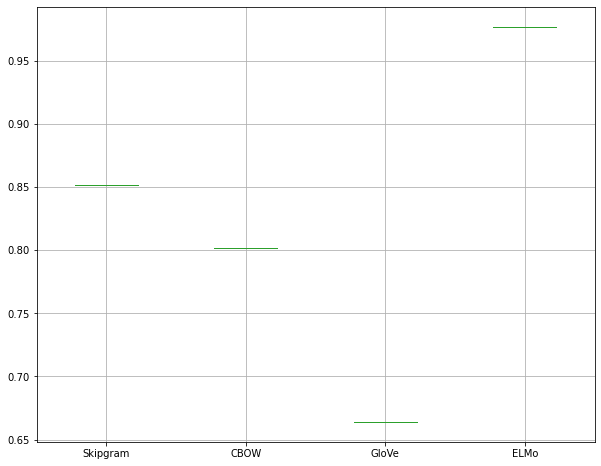

In [41]:
boxplot = accuracy_df.boxplot(figsize=(10,8))